In [727]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 

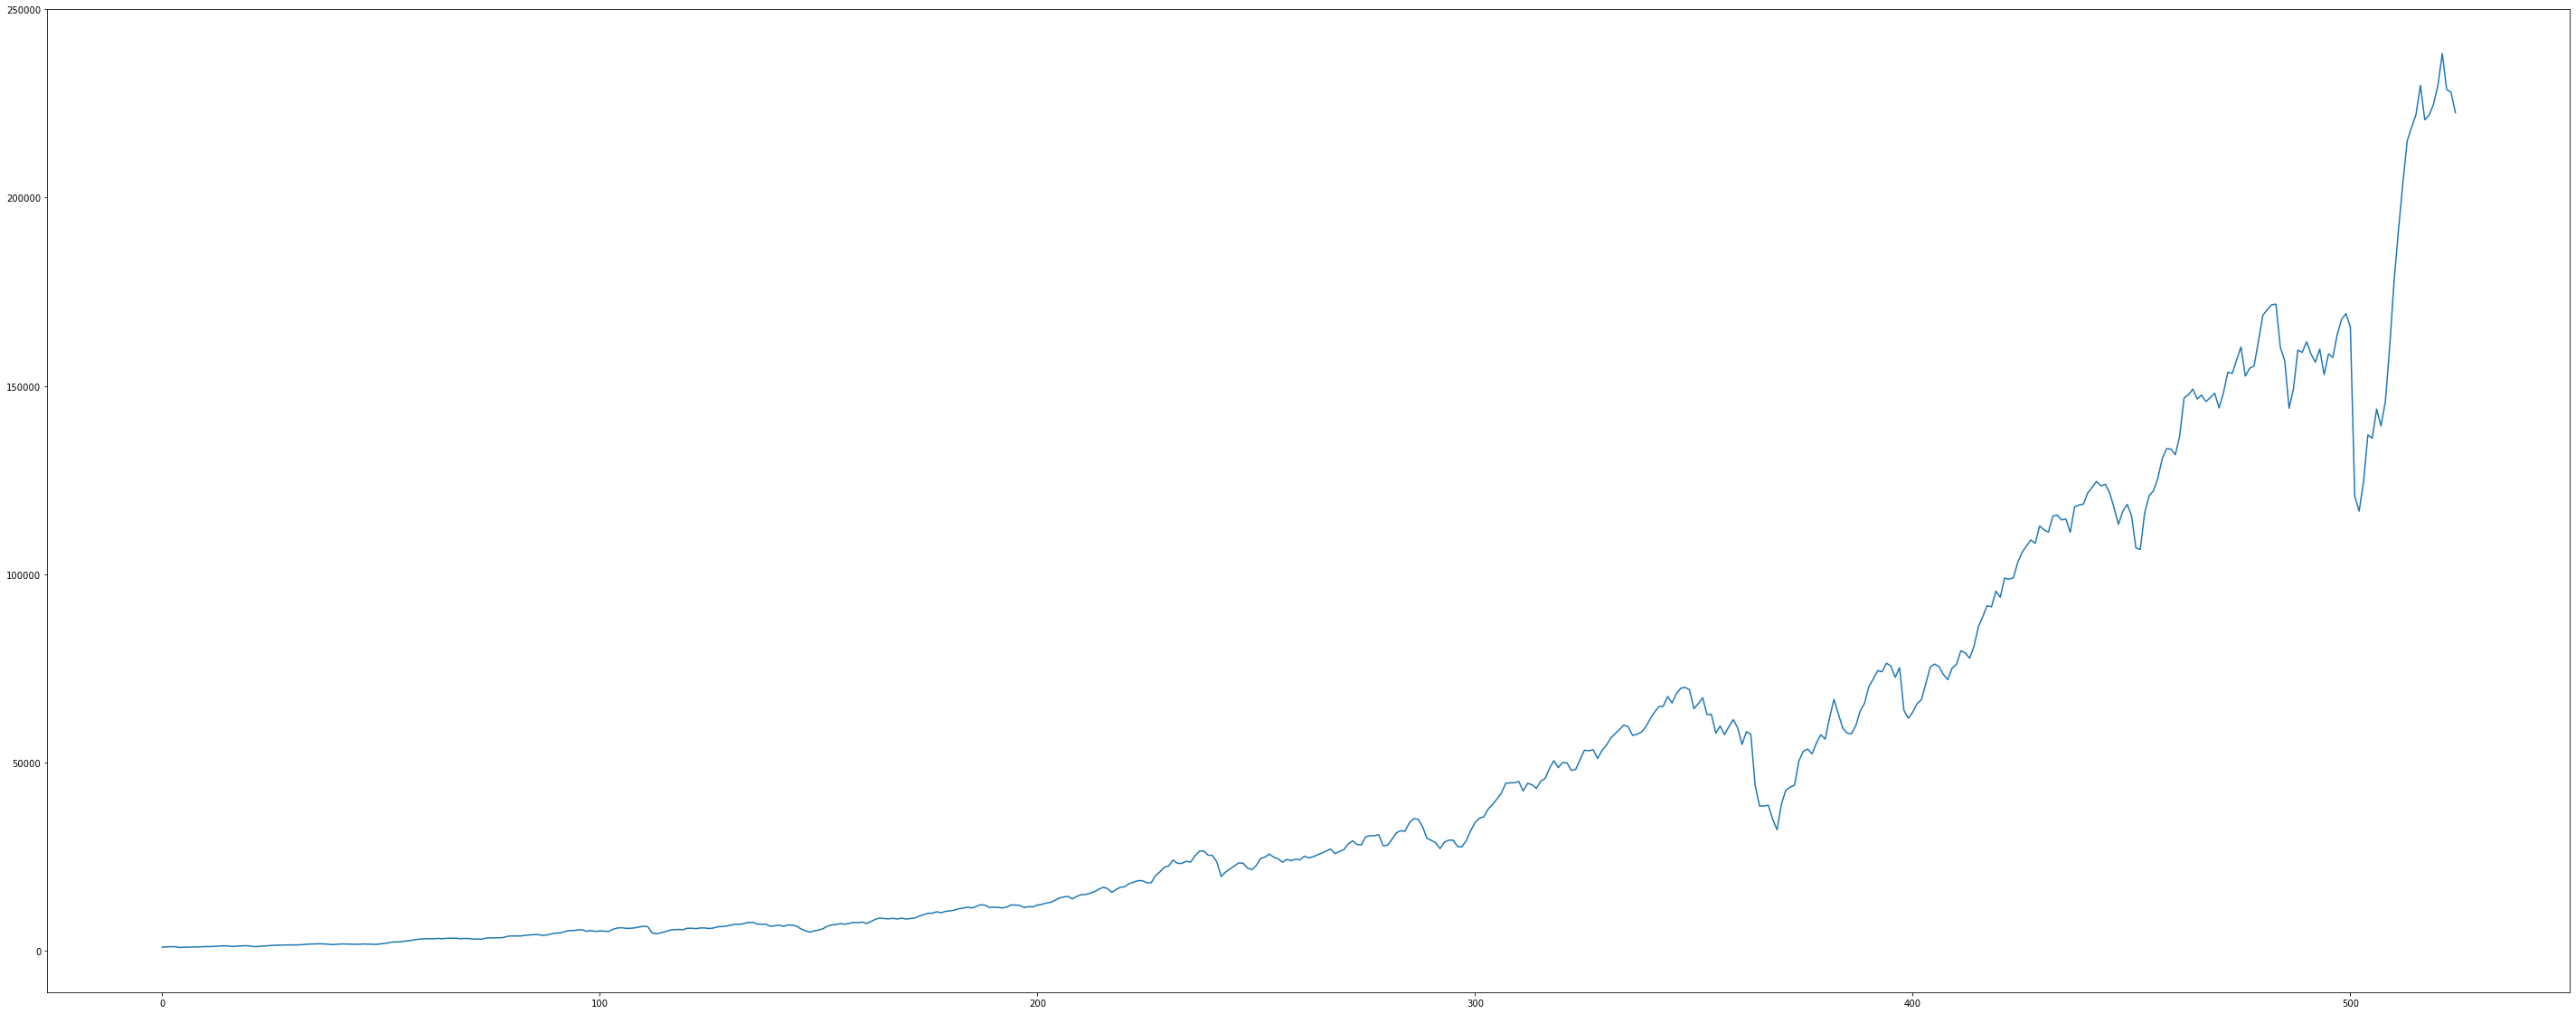

In [728]:
# load the data: the commented out part is the small cap growth stock index, not yet tested/used

df_fed = pd.read_csv('FEDFUNDS.csv')
df_sc_val = pd.read_csv('sc-val.csv')
#df_sc_gr = pd.read_csv('sc-gr.csv')

# PREPROCESSING: average the feature datapoints to monthly periodicity
df_sc_val = df_sc_val.groupby(pd.PeriodIndex(df_sc_val['DATE'], freq="M"))['VALUE'].mean().reset_index()
#df_sc_gr = df_sc_gr.groupby(pd.PeriodIndex(df_sc_gr['DATE'], freq="M"))['VALUE'].mean().reset_index()

# give our columns distinctive names: the data from FRED labels both of them as "VALUE"
val_value = "VAL_VALUE"
gr_value = "GR_VALUE"

df_sc_val.rename(columns={'VALUE':val_value}, inplace=True)
#df_sc_gr.rename(columns={'VALUE':gr_value}, inplace=True)

# combine the interest rate dataset with the value stock index dataset for further processing.
df_fed_val = df_fed.join(df_sc_val[val_value])

In [729]:
feature_val = df_fed_val["FEDFUNDS"].to_numpy().reshape(-1,1)
label_val = df_fed_val[val_value].to_numpy()

# PREPROCESSING: apply logarithmic scaling to the label data
label_val = np.log10(label_val)

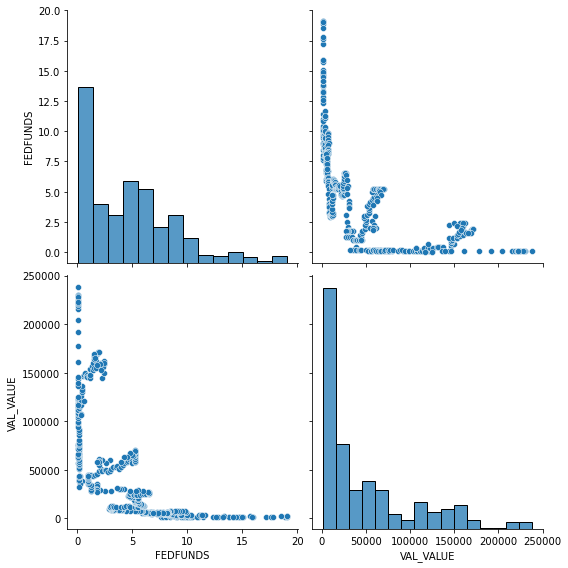

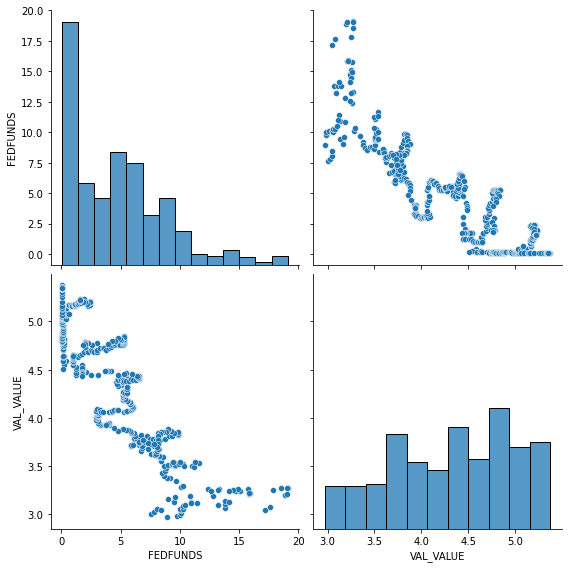

In [730]:
import seaborn as sns

# sanity check to see label is normalized

# not normalized:
sns.pairplot(df_fed_val, height=4)

# normalized
df_t = df_fed_val
df_t[val_value] = label_val
sns.pairplot(df_t, height=4)

In [731]:
# Split the dataset into a training set and a validation set at a 80/20 tr/val split in a random manner
X_train, X_val, y_train, y_val = train_test_split(feature_val, label_val, test_size=0.20, random_state=777)

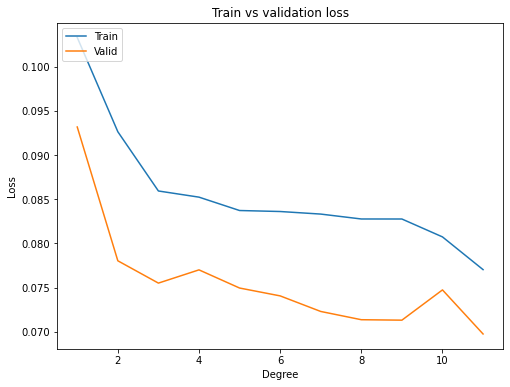

In [732]:
degrees = range(1,12)

# we will use this variable to store the resulting training errors for each polynomial degree
tr_errors = []          
val_errors = []

X_min = np.min(feature_val)
X_max = np.min(feature_val)

for i, degree in enumerate(degrees):    # use for-loop to fit polynomial regression models with different degrees
    
    # Linear regression 
    lin_regr = LinearRegression()
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    lin_regr.fit(X_train_poly, y_train)
    
    y_pred_train = lin_regr.predict(X_train_poly)
    tr_error = mean_squared_error(y_train, y_pred_train)
    X_val_poly = poly.fit_transform(X_val)
    y_pred_val = lin_regr.predict(X_val_poly)
    val_error = mean_squared_error(y_val, y_pred_val)
    
    tr_errors.append(tr_error)
    val_errors.append(val_error)

plt.figure(figsize=(8, 6))

plt.plot(degrees, tr_errors, label = 'Train')
plt.plot(degrees, val_errors,label = 'Valid')
plt.legend(loc = 'upper left')

plt.xlabel('Degree')
plt.ylabel('Loss')
plt.title('Train vs validation loss')
plt.show()